###  Задача 1. (2 балла)
Позволяет ли предсказывать корректные вероятности:

1) квадратичная функция потерь $L(y, z) =(y-z)^2$, 

2) экспоненциальная функция потерь $L(y, z) = \exp(-yz)$ ?

### Задача 2.  (2 балла)
Рассмотрим два вектора, $v_1=(1,1,2)$ и $v_2=(1,1,1)$. Переход в спрямляющее пространство осуществляется с помощью гауссовской ядерной функции $K(v,v {'})=\exp(-\gamma|v-v{'}|^2)$.
*  Как от $\gamma$ зависят длины векторов в спрямляющем пространстве?
*  Как от $\gamma$ зависит угол между векторами в спрямляющем пространстве?

### Задача 3. (2 балла) 

Является ли функция $K(x,z)=\cos(x-z)$ ядром?

### Задача 4. (4 балла)

In [1]:
%pylab inline
import pandas as pd
import numpy  as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


Сгенерируем синтетические данные:

In [2]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

####  1. Обучите метод опорных векторов. Воспользуйтесь классом [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [3]:
from sklearn.svm import LinearSVC

In [4]:
clf = LinearSVC(C=0.01) 
clf.fit(X_train, y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [5]:
y_pred=clf.predict(X_test)

#### 2. Чему равны доля верных предсказаний, точность, полнота и F-мера классификатора? 

In [6]:
from sklearn import metrics

print ('Accuracy =', metrics.accuracy_score(y_test, y_pred))
print ('Precision =', metrics.precision_score(y_test, y_pred))
print ('Recall =', metrics.recall_score(y_test, y_pred))
print ('F1 score =', metrics.f1_score(y_test, y_pred))

Accuracy = 0.7723333333333333
Precision = 0.7765251989389921
Recall = 0.7719182597231378
F1 score = 0.7742148760330578


#### 3.  Постройте ROC кривую. Определите AUC-ROC. 
Обратите внимание, что метод опорных векторов  не умеет predict_proba, но имеет метод decision_function.
Определите вероятности принадлежности к положительному классу как:
$$P(y=+1|x)=\frac{a(x)-\min(a_i)}{\max(a_i)-\min(a_i)}$$

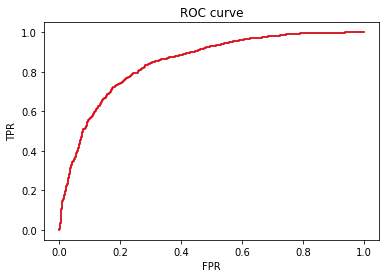

AUC - ROC : 0.84762


In [10]:
prob_pos = clf.decision_function(X_test)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

fpr,tpr, thresholds = metrics.roc_curve(y_test, prob_pos)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.plot(fpr, tpr, "r", label='Linear SVC')
plt.show()

print('AUC - ROC : {:.5f}'.format(metrics.roc_auc_score(y_test, prob_pos)))

#### 4. Калибровка вероятностей.  

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. 
#### Нарисуйте для найденных вероятностей калибровочную кривую, сравните с диагональю. 
Воспользуйтесь [calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html).

Text(0.5, 1.0, 'Calibration plot')

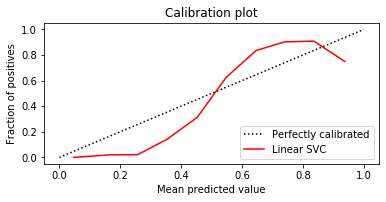

In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

prob_pos = clf.decision_function(X_test)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(mean_predicted_value, fraction_of_positives, label = 'Linear SVC', color= 'r')

ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="lower right")
ax.set_title('Calibration plot')


Воспользуйтесь [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV)из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [12]:
# SVC sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]


Text(0.5, 1.0, 'Calibration plot')

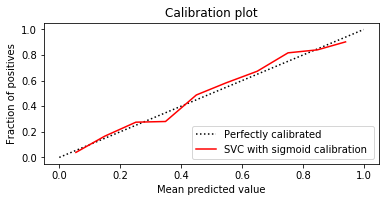

In [13]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_sigmoid, n_bins=10)

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value, fraction_of_positives, label = 'SVC with sigmoid calibration ', color= 'r')

ax1.set_xlabel("Mean predicted value")
ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Calibration plot')


In [14]:
# SVC with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'Calibration plot')

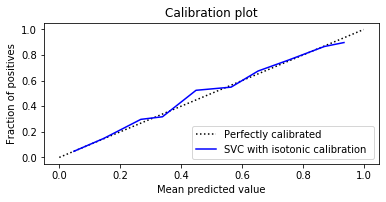

In [15]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)

ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(mean_predicted_value, fraction_of_positives, label = 'SVC with isotonic calibration ', color= 'b')

ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="lower right")
ax.set_title('Calibration plot')